This creates a model using the training data set.

# Normalize the length of list to be in [0,1] -- compare to embedding vectors of list

In [124]:
from __future__ import absolute_import, division, print_function, unicode_literals

seed = 23

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras 
from tensorflow.keras import Input, layers
tf.keras.backend.clear_session() # for easy reset of notebook state

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold

from matplotlib import pyplot as plt
from IPython import display
import pydot
from graphviz import Digraph
from matplotlib import pyplot as plt
from IPython import display

In [2]:
tf.__version__

'2.2.0'

In [3]:
np.random.random_seed = 23

Workflow:

- [x] establish DF with columns with: list of genres, length of list, gender
- [x] encode genres as integers (ordinal encoding) in pandas (don't use 1-num_genre_labels)
- [x] create arrays of fixed length (max length of genre list) with integer encodings of genre labels and padded with zeros
- [ ] NOTE: currently not using this -- using numpy arrays; load dataframe into TF Dataset with columns for codes of genre labels (num_cols = max_num genre labels), length of list, gender
    - https://www.tensorflow.org/tutorials/load_data/pandas_dataframe
- [x] transform gender to 0,1 -- used pd.Categorical
- [x] split into train and validation
- [x] define model 
    - [x] embedding layer of the genrelist columns
    - [x] dense input for the number of genrelabels
- [x] train
- [x] add cross validation
    - [x] split length and list in pandas
    - [ ] split lengthh and list using feature columns in TF
- [ ] tune
    - [ ] 1-cycle
    - [ ] regularization
    - [ ] residual connections

Other versions:

- [ ] following https://www.tensorflow.org/guide/keras/functional
     - [ ] in DataFrame have variable length tuple of genre codes 
     - [ ] use an input layer with shape = (None,)
- [ ] get keras.utils.plot_model to work



May be helpful:

https://www.tensorflow.org/tutorials/structured_data/feature_columns


Later try using sparse tensors:


Work flow:

Create a dataset from a pandas DataFrame:

https://www.tensorflow.org/tutorials/load_data/pandas_dataframe

But use sparse tensors:

https://www.tensorflow.org/api_docs/python/tf/sparse/SparseTensor


First try to go directly from the dataframe with the ordinal encoding of the genre labels to a sparse matrix by extracting the index, value info. If that doesn't work:

Use the scipy sparse matrix that and convert from scipy sparse matrix to tf sparse tensor:

https://stackoverflow.com/questions/40896157/scipy-sparse-csr-matrix-to-tensorflow-sparsetensor-mini-batch-gradient-descent

Also read:

https://www.tensorflow.org/guide/data

Import the DF of genre lists and gender:

In [4]:
%store -r now
now
X_train = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_X_train_{}.csv'.format(now), index_col = ['artist'])
y_train = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_y_train_{}.csv'.format(now), index_col = ['artist'])

### Genre Labels -- as a list

Each value of the genre column is a _string_ of comma separated genre labels using the spotify abbreviations. We want to convert it to a _list_ of strings.

In [5]:
"""This function takes in a string of the form
appearing in the genrelist of the dataframe.
It strips the square brackets and extra quotes and
returns a list of strings where each string is a genre label."""
def genrelist(string):
    string = string.strip("[").strip("]").replace("'","")
    L = [s for s in string.split(',')]
    L_new = []
    for x in L:
        L_new.append(x.replace(" ","_").lstrip("_").rstrip("_"))
    while (str("") in L_new):
        L_new.remove("")
    return L_new

Now we apply it to the whole column and put the lists in a new column:

In [6]:
X_train['genrelist']= X_train['genrelist'].apply(genrelist)

In [7]:
data = X_train.join(y_train, how = 'inner', on = 'artist')

In [8]:
data.reset_index(inplace = True)
data.index.name = 'artist_id'

In [9]:
data.head()

,artist,genrelist,genrelist_length,gender
artist_id,,,,
0,Pablo_Holman,"[pop, rock, emo_pop]",3,male
1,Bobby_Edwards,[country],1,male
2,La_Palabra,"[afro_cuban_jazz, son_montuno, guaracha, salsa...",4,male
3,Sherrick,"[r_and_b, soul]",2,male
4,Allen_Collins,[southern_rock],1,male


Full genre_list (not just that for the training set)

In [10]:
genre_list = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/genre_list_{}.csv'.format(now))
genre_list.drop(['Unnamed: 0'], axis = 1, inplace = True)
genre_list['genre_id'] = list(range(1,genre_list.shape[0]+1))

In [11]:
genre_list.head(10)

,genre_list,genre_id
0,chilean,1
1,zamba,2
2,afro_punk_blues,3
3,crunk,4
4,spanish_guitar,5
5,chanson,6
6,cybergrind,7
7,outsider,8
8,folk_alternative,9
9,alternative_music,10


Size of the vocab:

In [12]:
vocab_size = genre_list.shape[0]

In [13]:
vocab_size

1494

Create a dictionary {genre_label: genre_id}

In [14]:
genre_list.set_index(['genre_list'], inplace = True)

In [15]:
genre_list.head()

,genre_id
genre_list,
chilean,1
zamba,2
afro_punk_blues,3
crunk,4
spanish_guitar,5


In [16]:
genre_list.tail()

,genre_id
genre_list,
british_rock,1490
funeral_doom_metal,1491
blues_soul,1492
mainstream,1493
canción,1494


In [17]:
label_id_dict = genre_list['genre_id'].to_dict()

In [18]:
label_id_dict['pop']

1007

Find max length of genre lists:

In [19]:
max_list_length = data.genrelist_length.max()
max_list_length

73

In [20]:
def encode_list(row):
    return [label_id_dict[item] for item in row.genrelist]

In [21]:
data['genres_encoded_as_list'] = data.apply(encode_list, axis = 1)

In [22]:
data.head()

,artist,genrelist,genrelist_length,gender,genres_encoded_as_list
artist_id,,,,,
0,Pablo_Holman,"[pop, rock, emo_pop]",3,male,"[1007, 1431, 794]"
1,Bobby_Edwards,[country],1,male,[465]
2,La_Palabra,"[afro_cuban_jazz, son_montuno, guaracha, salsa...",4,male,"[1442, 1357, 1004, 809]"
3,Sherrick,"[r_and_b, soul]",2,male,"[1426, 359]"
4,Allen_Collins,[southern_rock],1,male,[1186]


Check that the encoding is consistent:

In [23]:
n = np.random.randint(data.shape[0])
[label_id_dict[item] for item in data.genrelist.iloc[n]], data.genres_encoded_as_list.iloc[n]

([1431, 1007], [1431, 1007])

not used: Create the column with the array of fixed length padded with zeros:

In [24]:
# def encode_array(row):
#     arr = np.zeros((73), dtype = 'int64')
#     for i, id in enumerate(row.genres_encoded_as_list):
#         arr[i] = id
#     return arr

Encode into new columns

In [25]:
for i in range(73):
    data['label_{}'.format(i)] = np.zeros((data.shape[0]), dtype = 'int64')

In [26]:
def encode_columns(row):
    for i, id in enumerate(row.genres_encoded_as_list):
        row.loc['label_{}'.format(i)] = id
    return row

In [27]:
# data_train['genres_encoded'] = data_train.apply(encode_array, axis = 1)

In [28]:
data = data.apply(encode_columns, axis = 1)

In [29]:
data.head()

,artist,genrelist,genrelist_length,gender,genres_encoded_as_list,label_0,label_1,label_2,label_3,label_4,...,label_63,label_64,label_65,label_66,label_67,label_68,label_69,label_70,label_71,label_72
artist_id,,,,,,,,,,,,,,,,,,,,,
0,Pablo_Holman,"[pop, rock, emo_pop]",3,male,"[1007, 1431, 794]",1007,1431,794,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bobby_Edwards,[country],1,male,[465],465,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,La_Palabra,"[afro_cuban_jazz, son_montuno, guaracha, salsa...",4,male,"[1442, 1357, 1004, 809]",1442,1357,1004,809,0,...,0,0,0,0,0,0,0,0,0,0
3,Sherrick,"[r_and_b, soul]",2,male,"[1426, 359]",1426,359,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Allen_Collins,[southern_rock],1,male,[1186],1186,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Encode targets. The categories still appear as strings. To see the encoding use df.column.cat.codes.

In [30]:
#data['gender'] = pd.Categorical(data['gender'], categories = ['male','female'])

In [31]:
data['gender'] = data.gender.apply(lambda x: 1 if x == 'female' else 0)

In [32]:
data = data.drop(['artist','genrelist', 'genres_encoded_as_list'], axis = 1)

In [33]:
data.head()

,genrelist_length,gender,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,...,label_63,label_64,label_65,label_66,label_67,label_68,label_69,label_70,label_71,label_72
artist_id,,,,,,,,,,,,,,,,,,,,,
0,3,0,1007,1431,794,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,465,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,1442,1357,1004,809,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,1426,359,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1186,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
data.shape, data.dtypes

((12376, 75),
 genrelist_length    int64
 gender              int64
 label_0             int64
 label_1             int64
 label_2             int64
                     ...  
 label_68            int64
 label_69            int64
 label_70            int64
 label_71            int64
 label_72            int64
 Length: 75, dtype: object)

Shuffle the data:

In [35]:
data = data.sample(frac = 1)

In [36]:
data_set_size = data.shape[0]

Now split into X,y DFs

In [37]:
y = data.pop('gender')
X = data.copy()

In [45]:
X.head()

,genrelist_length,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,...,label_63,label_64,label_65,label_66,label_67,label_68,label_69,label_70,label_71,label_72
artist_id,,,,,,,,,,,,,,,,,,,,,
10345,4,860,133,293,422,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11759,1,650,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9397,3,870,959,179,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2217,3,449,667,740,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4710,4,1415,684,1365,173,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Define Model

Do I need normalization?

In [197]:
def create_model():
    loss_fcn = keras.losses.BinaryCrossentropy(from_logits=True)
    lr = .001
    lam = .0001
    #opt = tfa.optimizers.AdamW(lr = lr, weight_decay = .001)
    opt = tf.keras.optimizers.Adam(lr = lr)
    
    reg = tf.keras.regularizers.l2(lam)
    
    # the list input; use vocab_size+1 since 0 is saved to indicate no label
    list_input = layers.Input(shape = (max_list_length,), name = 'list_input')
    embed = layers.Embedding(input_dim = vocab_size+1, output_dim = 500, input_length = max_list_length, name = 'list_embed')(list_input)
    pool = layers.GlobalAveragePooling1D()(embed)
    # the length input
    length_input = layers.Input(shape = (1,), name = 'length_input')
    # concatenate two inputs
    x = layers.concatenate([pool, length_input])
    # add dense layers
    x = layers.Dense(64, activation = 'relu')(x)
    x = layers.concatenate([x, length_input])
    x = layers.Dropout(.2)(x)
    # bring length input back
    x = layers.Dense(64, activation = 'relu')(x)
    x = layers.Dropout(.4)(x)
    x = layers.Dense(32, activation = 'relu')(x)
    x = layers.Dropout(.4)(x)
    x = layers.Dense(32, activation = 'relu')(x)
    pred = layers.Dense(1, name = 'predictions')(x)

    model = keras.Model(inputs = [list_input, length_input], outputs = [pred])
    
    
    model.compile(loss=loss_fcn,
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

In [198]:
# need to install pydot (pip) and graphviz (conda)
#keras.utils.plot_model(model, 'dnn_0_model_graph.png', show_shapes = True)

In [199]:
#model.summary()

### Train Model

In [200]:
X_values = X.values
y_values = y.values

X_0_train = X_values[:,0:1]
X_1_train = X_values[:,1:74]
y_train = np.asarray(y_values)

model = create_model()

history = model.fit({'list_input':X_1_train, 'length_input':X_0_train},
                    {'predictions':y_train},
                    batch_size=16,
                    epochs=20
                    )

#test_scores = model.evaluate(dataset_val, verbose=2)

Epoch 1/20
774/774 [==============================] - 8s 10ms/step - loss: 0.6177 - accuracy: 0.6892
Epoch 2/20
774/774 [==============================] - 8s 11ms/step - loss: 0.5435 - accuracy: 0.6958
Epoch 3/20
774/774 [==============================] - 8s 11ms/step - loss: 0.5189 - accuracy: 0.7031
Epoch 4/20
774/774 [==============================] - 14s 17ms/step - loss: 0.5106 - accuracy: 0.7093
Epoch 5/20
774/774 [==============================] - 14s 18ms/step - loss: 0.5026 - accuracy: 0.7160
Epoch 6/20
774/774 [==============================] - 10s 13ms/step - loss: 0.4964 - accuracy: 0.7222
Epoch 7/20
774/774 [==============================] - 14s 18ms/step - loss: 0.4894 - accuracy: 0.7254
Epoch 8/20
774/774 [==============================] - 9s 12ms/step - loss: 0.4881 - accuracy: 0.7276
Epoch 9/20
774/774 [==============================] - 8s 11ms/step - loss: 0.4833 - accuracy: 0.7309
Epoch 10/20
774/774 [==============================] - 8s 11ms/step - loss: 0.4796 - ac

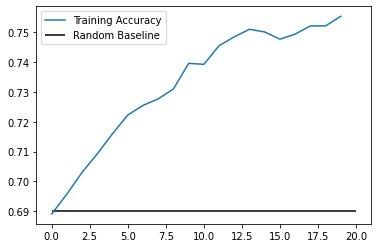

In [202]:
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.hlines(0.69,0,len(history.history['accuracy']), label = 'Random Baseline')
#plt.ylim(0,.1)
plt.legend()
plt.show()
#print(min(history.history['accuracy']))

Train with cross validation:

In [203]:
kf = KFold(n_splits = 10, shuffle = True, random_state = seed)

cvscores_acc = []

X_values = X.values
y_values = y.values

for train, test in kf.split(X_values,y_values):
    
    X_0_train = X_values[train,0:1]
    X_1_train = X_values[train,1:74]
    y_train = np.asarray(y_values[train])
    
    #print(X_0_train.shape, X_1_train.shape, y_train.shape)
    
    model = create_model()
    
#     dataset_length_train = tf.data.Dataset.from_tensor_slices((X_0_train, y_train)) 
#     dataset_list_train = tf.data.Dataset.from_tensor_slices((X_1_train, y_train)) 
    
    history = model.fit({'list_input':X_1_train, 'length_input':X_0_train},
                    {'predictions':y_train},
                    batch_size=16,
                    epochs=40,
                    verbose = 0 
                    )
    
    
    X_0_test = X_values[test,0:1]
    X_1_test = X_values[test,1:73]
    y_test = y_values[test]
    
#     dataset_length_test = tf.data.Dataset.from_tensor_slices((X_0_test, y_test)) 
#     dataset_list_test = tf.data.Dataset.from_tensor_slices((X_1_test, y_test)) 
    
    scores = model.evaluate(
                    {'list_input':X_1_train, 'length_input':X_0_train},
                    {'predictions':y_train},
                    verbose = 0)
    
    print(f'Accuracy = {scores[1]}.')
    cvscores_acc.append(scores[1])
    

print(f'Mean Accuracy is {np.mean(cvscores_acc):.4f} and STD of Accuracy is {np.std(cvscores_acc):.4f}')

Accuracy = 0.7739270925521851.
Accuracy = 0.7760818600654602.
Accuracy = 0.746453583240509.
Accuracy = 0.7574070692062378.
Accuracy = 0.7336146235466003.
Accuracy = 0.7557011842727661.
Accuracy = 0.7502468824386597.
Accuracy = 0.7313941717147827.
Accuracy = 0.7507855296134949.
Accuracy = 0.7415387630462646.
Mean Accuracy is 0.7517 and STD of Accuracy is 0.0142


Ignore for now: Another possibility: Create TF Dataset using the corpus from gensim as a generator: Another possibility: Create TF Dataset using the corpus from gensim as a generator:

In [ ]:
def corpus_gen():
    for i in len(corpus):
        yield (i, corpus[i])

In [ ]:
dataset = tf.data.Dataset.from_generator(
    corpus_gen,
    (tf.int64, --tensor_one_hot--)
)